시퀀스 데이터를 처리하는 기본적인 딥러닝 모델은 순환 신경망과 1D 컨브넷 두 가지입니다.

- 문서 분류나 시계열 분류 : 예를 들어 글의 주제나 책의 저자 식별하기
- 시계열 비교 : 예를 들어 두 문서나 두 주식 가격이 얼마나 밀접하게 관련이 있는지 추정하기
- 시퀀스-투-시퀀스 학습 : 예를 들어 영어 문장을 프랑스어로 변환하기
- 감성 분석 : 예를 들어 트윗이나 영화 리뷰가 긍정적인지 부정적인지 분류하기
- 시계열 예측 : 예를 들어 어떤 지역의 최근 날씨 데이터가 주어졌을 때 향후 날씨 예측하기

# 텍스트 데이터 다루기
텍스트는 가장 흔한 시퀀스 형태의 데이터입니다. 텍스트를 수치형 텐서로 변환하는 과정을 텍스트 벡터화라고 합니다.

- 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환합니다.
- 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환합니다.
- 텍스트에서 단어나 문자의 n-그램을 추출하여 각 n-그램을 하나의 벡터로 변환합니다. n-그램은 연속된 단어나 문자의 그룹으로 텍스트에서 단어나 문자를 하나씩 이동하면서 추출합니다.

텍스트를 나누는 이런 단위(단어, 문자, n-그램)를 토큰이라고 합니다. 그리고 텍스트를 토큰으로 나누는 작업을 토큰화라고 합니다.
토큰과 벡터를 연결하는 방법은 원 핫 인코딩과 토큰 임베딩이 있습니다.

## 단어와 문자의 원-핫 인코딩
원-핫 인코딩은 토큰을 벡터로 변환하는 가장 일반적이고 기본적인 방법입니다.

In [1]:
# 단어 수준의 원-핫 인코딩 하기
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
max_length = 10

results = np.zeros(shape=(len(samples),
                         max_length,
                         max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [2]:
# 문자 수준의 원-핫 인코딩하기
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [3]:
# 케라스를 사용한 원-핫 인코딩하기

from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

9개의 고유한 토큰을 찾았습니다.


In [4]:
# 해싱 기법을 사용한 단어 수준의 원-핫 인코딩하기

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

## 단어 임베딩 사용하기
보통 256차원, 512차원 또는 큰 어휘 사전을 다룰 때는 1,024차원의 단어 임베딩을 사용합니다. 2만 개의 토큰으로 이루어진 어휘 사전을 만들려면 원-핫 인코딩은 20,000차원 또는 그 이상의 벡터일 경우가 많습니다. 따라서 단어 임베딩이 더 많은 정보를 적은 차원에 저장합니다.

- (문서 분류나 감성 예측 같은) 관심 대상인 문제와 함께 단어 임베딩을 학습합니다. 이런 경우에는 랜덤한 단어 벡터로 시작해서 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습합니다.
- 풀려는 문제가 아니고 다른 머신 러닝 작업에서 미리 계산된 단어 임베딩을 로드합니다. 이를 사전 훈련된 단어 임베딩이라고 합니다.

## Embedding 층을 사용하여 단어 임베딩 학습하기
단어와 밀집 벡터를 연관 짓는 가장 간단한 방법은 랜덤하게 벡터를 선택하는 것입니다. 이 방식의 문제점은 임베딩 공간이 구조적이지 않다는 것입니다.
실제 단어 임베딩 공간에서 의미 있는 기하학적 변환의 일반적인 예는 '성별' 벡터와 '복수'벡터입니다. 예를 들어 'king'벡터에 'female'벡터를 더하면 'queen'벡터가 됩니다. 'plural'벡터를 더하면 'kings'가 됩니다.  
Embedding 층을 정수 인덱스를 밀집 벡터로 매핑하는 딕셔너리로 이해하는 것이 가장 좋습니다. 정수를 입력으로 받아 내부 딕셔너리에서 이 정수에 연관된 벡터를 찾아 반환합니다.  
Embedding 층은 크기가 (samples, sequence_length)인 2D 정수 벡터를 입력으로 받고, (samples, sequence_length, embedding_dimensionality)인 3D 실수형 텐서를 반환합니다.

In [5]:
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

In [10]:
# %load np_load_allow_pickle_True.py
import numpy as np 
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# np.load 사용 후 반드시 아래 코드를 실행할 것!!!
# np.load = np_load_old

In [11]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 108us/step - loss: 0.6759 - acc: 0.6043 - val_loss: 0.6398 - val_acc: 0.6810
Epoch 2/10
20000/20000 [==============================] - 1s 73us/step - loss: 0.5657 - acc: 0.7428 - val_loss: 0.54

## 사전 훈련된 단어 임베딩 사용하기
사전 훈련된 컨브넷을 사용하는 이유와 같다.(= 소량 데이터를 학습시키기 위함)  
가장 유명한 것은 word2vec과 GloVe이다.

## 모든 내용을 적용하기 : 원본 텍스트에서 단어 임베딩까지

In [3]:
import os

imdb_dir = './datasets/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [7]:
glove_dir = './datasets/'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embedding_index))

400000개의 단어 벡터를 찾았습니다.


In [6]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

NameError: name 'embedding_index' is not defined

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 사전 훈련된 데이터를 
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [24]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2018 - acc: 0.5000 - val_loss: 0.7379 - val_acc: 0.4967
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5220 - acc: 0.7550 - val_loss: 1.5121 - val_acc: 0.4936
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5323 - acc: 0.7400 - val_loss: 0.9402 - val_acc: 0.4942
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 0.3645 - acc: 0.8550 - val_loss: 0.6827 - val_acc: 0.5661
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2080 - acc: 0.9950 - val_loss: 0.7032 - val_acc: 0.5615
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2648 - acc: 0.8800 - val_loss: 0.7341 - val_acc: 0.5431
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1375 - acc: 0.9800 - val_loss: 0.7051 - val_acc: 0.5676
Epoch 8/10
200/200 [========

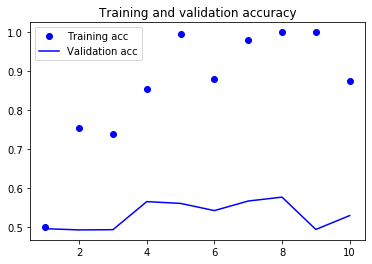

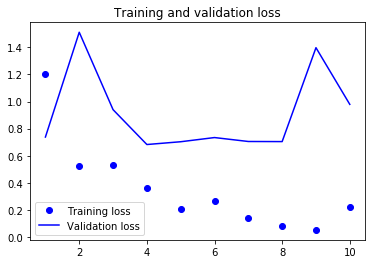

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6956 - acc: 0.4500 - val_loss: 0.6921 - val_acc: 0.5195
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5374 - acc: 0.9750 - val_loss: 0.6932 - val_acc: 0.5176
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3277 - acc: 0.9900 - val_loss: 0.7014 - val_acc: 0.5128
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1574 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.5252
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0750 - acc: 1.0000 - val_loss: 0.7043 - val_acc: 0.5281
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0387 - acc: 1.0000 - val_loss: 0.7108 - val_acc: 0.5259
Epoch 7/10
200/200 [==============================] - 0s 2ms/st

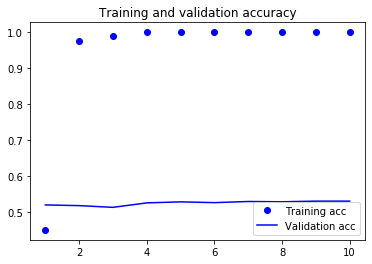

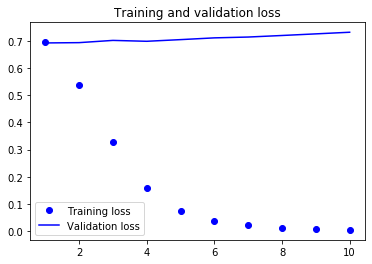

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [13]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 47us/step


[0.9933327033805848, 0.5204]

## 정리

- 원본 텍스트를 신경망이 처리할 수 있는 형태로 변환합니다.
- 케라스 모델에 Embedding 층을 추가하여 어떤 작업에 특화된 토큰 임베딩을 학습합니다.
- 데이터가 부족한 자연어 처리 문제에서 사전 훈련된 단어 임베딩을 사용하여 성능 향상을 꾀합니다.